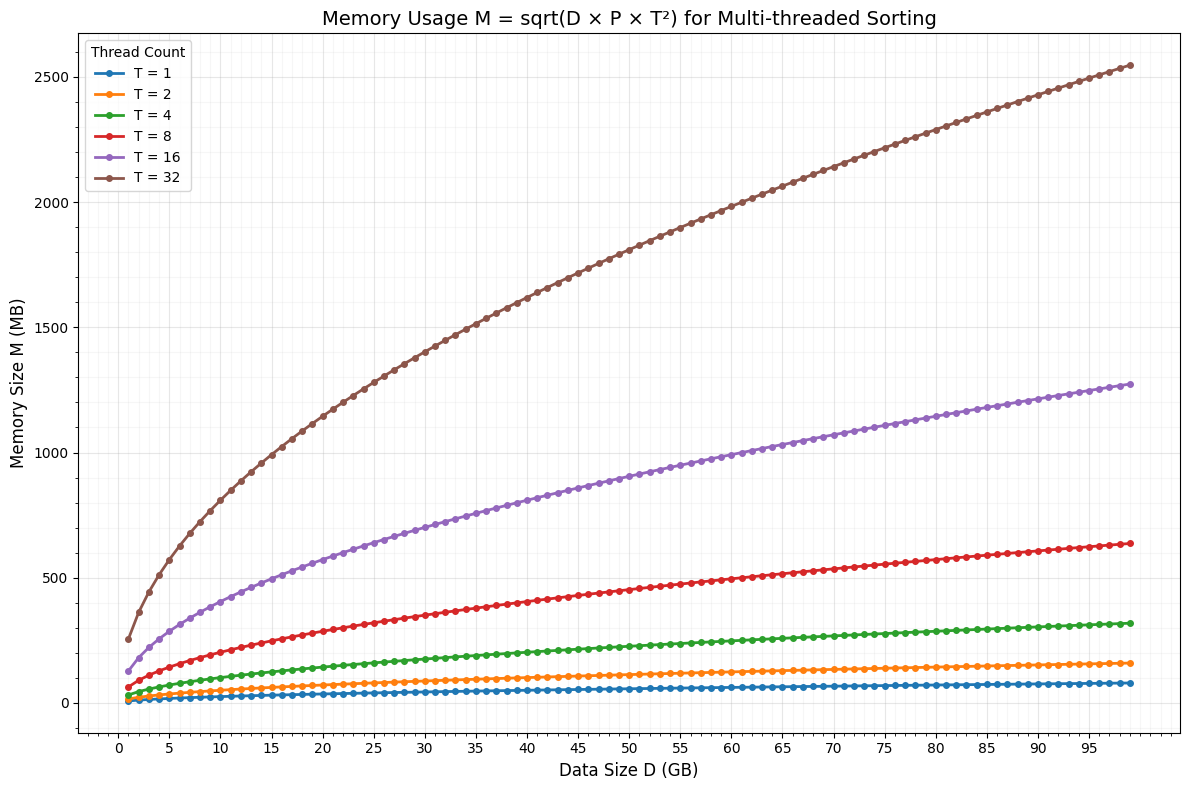

Example values (Memory in MB):
D (GB)     T=1        T=2        T=4        T=8        T=16       T=32      
----------------------------------------------------------------------
1         8.00      16.00     32.00     64.00     128.00    256.00    
2         11.31     22.63     45.25     90.51     181.02    362.04    
4         16.00     32.00     64.00     128.00    256.00    512.00    
8         22.63     45.25     90.51     181.02    362.04    724.08    
16        32.00     64.00     128.00    256.00    512.00    1024.00   
32        45.25     90.51     181.02    362.04    724.08    1448.15   
64        64.00     128.00    256.00    512.00    1024.00   2048.00   
128       90.51     181.02    362.04    724.08    1448.15   2896.31   

M/T ratios (Memory per thread in MB):
D (GB)     T=1        T=2        T=4        T=8        T=16       T=32      
----------------------------------------------------------------------
1         8.00      8.00      8.00      8.00      8.00      8.00  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
P = 64 * 1024  # Page size in bytes (64KB)
MB = 1024 * 1024  # Bytes to MB conversion factor
GB = 1024 * 1024 * 1024  # Bytes to GB conversion factor

# Data sizes D from 1GB to 50GB
D_values = np.arange(1, 100) * GB  # in bytes
D_labels = np.arange(1, 100)  # for x-axis labels (in GB)

# Thread counts
T_values = [1, 2, 4, 8, 16, 32]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot for each thread count
for T in T_values:
    M_values = np.sqrt(D_values * P * T**2) / MB  # Memory in MB
    plt.plot(D_labels, M_values, marker='o', markersize=4, label=f'T = {T}', linewidth=2)

# Formatting
plt.xlabel('Data Size D (GB)', fontsize=12)
plt.ylabel('Memory Size M (MB)', fontsize=12)
plt.title('Memory Usage M = sqrt(D × P × T²) for Multi-threaded Sorting', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Thread Count', loc='upper left')

# Set x-axis ticks at reasonable intervals
plt.xticks(np.arange(0, 100, 5), fontsize=10)

# Add minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', alpha=0.1)

# Tight layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()

# Print some example values for verification
print("Example values (Memory in MB):")
print(f"{'D (GB)':<10} {'T=1':<10} {'T=2':<10} {'T=4':<10} {'T=8':<10} {'T=16':<10} {'T=32':<10}")
print("-" * 70)
for d_gb in [1, 2, 4, 8, 16, 32, 64, 128]:
    d_bytes = d_gb * GB
    print(f"{d_gb:<10}", end="")
    for t in T_values:
        m_mb = np.sqrt(d_bytes * P * t**2) / MB
        print(f"{m_mb:<10.2f}", end="")
    print()

# Print M/T ratios
print("\nM/T ratios (Memory per thread in MB):")
print(f"{'D (GB)':<10} {'T=1':<10} {'T=2':<10} {'T=4':<10} {'T=8':<10} {'T=16':<10} {'T=32':<10}")
print("-" * 70)
for d_gb in [1, 2, 4, 8, 16, 32, 64, 128]:
    d_bytes = d_gb * GB
    print(f"{d_gb:<10}", end="")
    for t in T_values:
        m_mb = np.sqrt(d_bytes * P * t**2) / MB
        ratio = m_mb / t
        print(f"{ratio:<10.2f}", end="")
    print()